## Collect images using openCV

In [1]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_path = os.path.join('data1','images')
number_images = 30

In [9]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Annotate the  images


In [10]:
!labelme

[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\shyam suthar\.labelmerc


# Review Dataset and Build Image Loading Function

##  Import TF and Deps

In [11]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [14]:
images = tf.data.Dataset.list_files('data1\\images\\*.jpg')

In [15]:
images.as_numpy_iterator().next()

b'data1\\images\\16274531-dc13-11ec-ad25-a87eeaad3841.jpg'

In [16]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [17]:
images = images.map(load_image)

In [18]:
images.as_numpy_iterator().next()

array([[[180, 177, 184],
        [180, 177, 184],
        [182, 177, 184],
        ...,
        [105, 102,  87],
        [105, 103,  88],
        [105, 103,  88]],

       [[178, 175, 182],
        [178, 175, 182],
        [180, 175, 182],
        ...,
        [105, 102,  87],
        [104, 102,  87],
        [104, 102,  87]],

       [[180, 175, 181],
        [180, 175, 181],
        [180, 175, 181],
        ...,
        [103, 101,  86],
        [103, 101,  88],
        [103, 101,  88]],

       ...,

       [[ 71,  44,  35],
        [ 72,  45,  36],
        [ 73,  46,  37],
        ...,
        [140, 142, 131],
        [141, 142, 134],
        [141, 142, 134]],

       [[ 67,  42,  38],
        [ 68,  43,  39],
        [ 69,  44,  39],
        ...,
        [138, 142, 128],
        [140, 142, 131],
        [140, 142, 131]],

       [[ 65,  39,  38],
        [ 66,  40,  39],
        [ 67,  42,  38],
        ...,
        [137, 141, 127],
        [138, 140, 129],
        [137, 139, 128]]

In [19]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

#  View Raw Images with Matplotlib

In [20]:
image_generator = images.batch(4).as_numpy_iterator()

In [21]:
plot_images = image_generator.next()

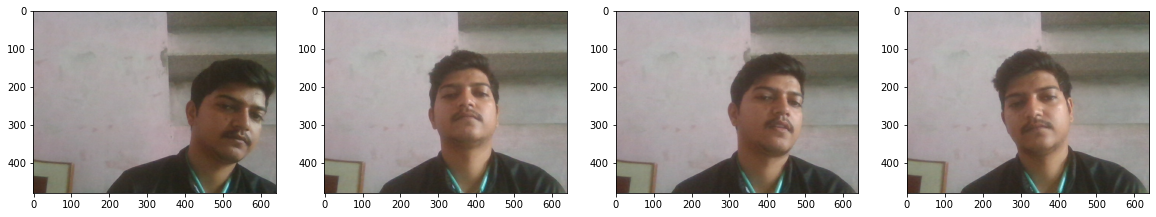

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partition Unaugmented Data

## MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [23]:
# here we can also use sklearn library for train test split the data 
30 * 0.7 # 21 to train

21.0

In [26]:
30 * .3 # 4 and 5 to val and test

9.0

## Move the Matching Labels

In [29]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data1', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data1','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data1',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

## Apply Image Augmentation on Images and Labels using Albumentations

In [35]:
import albumentations as alb

In [36]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## Load a Test Image and Annotation with OpenCV and JSON

In [37]:
img = cv2.imread(os.path.join('data1','train', 'images','1a98e501-dc13-11ec-87d7-a87eeaad3841.jpg'))

In [38]:
with open(os.path.join('data1', 'train', 'labels', '1a98e501-dc13-11ec-87d7-a87eeaad3841.json'), 'r') as f:
    label = json.load(f)

In [39]:
label['shapes'][0]['points']

[[235.10052910052906, 107.99470899470899],
 [458.91005291005285, 370.4285714285714]]

## Extract Coordinates and Rescale to Match Image Resolution

In [40]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [41]:
coords

[235.10052910052906, 107.99470899470899, 458.91005291005285, 370.4285714285714]

In [42]:
coords = list(np.divide(coords, [640,480,640,480]))

In [43]:
coords

[0.36734457671957665,
 0.2249889770723104,
 0.7170469576719576,
 0.7717261904761904]

In [44]:
#Apply Augmentations and View Results
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [45]:
augmented['bboxes'][0][2:]

(0.7464432686654909, 0.8066784244562022)

In [46]:
augmented['bboxes']

[(0.2490887713109936,
  0.22349206349206363,
  0.7464432686654909,
  0.8066784244562022)]

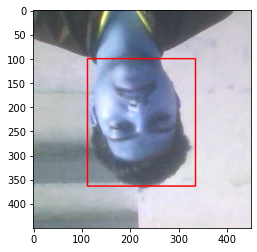

In [47]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [53]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data1', partition, 'images')):
        img = cv2.imread(os.path.join('data1', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data1', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.9807705026455025, 0.2734898589065256, 0.612880291005291, 0.8257385361552028, 'face'].


## Load Augmented Images to Tensorflow Dataset

In [54]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [55]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [56]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [57]:
train_images.as_numpy_iterator().next()

array([[[0.26666668, 0.16862746, 0.2509804 ],
        [0.2764706 , 0.17843138, 0.26078433],
        [0.25637254, 0.16323529, 0.24313726],
        ...,
        [0.07990196, 0.05196078, 0.06911765],
        [0.07794118, 0.05441177, 0.07009804],
        [0.07058824, 0.05042892, 0.0622549 ]],

       [[0.2602941 , 0.1622549 , 0.24460784],
        [0.27009803, 0.17205882, 0.25441176],
        [0.26715687, 0.16911764, 0.2514706 ],
        ...,
        [0.09699755, 0.05484069, 0.0778799 ],
        [0.08878677, 0.05477941, 0.07395833],
        [0.075     , 0.04117647, 0.06029412]],

       [[0.25490198, 0.15686275, 0.23921569],
        [0.25882354, 0.16078432, 0.24313726],
        [0.25876224, 0.16072305, 0.24307598],
        ...,
        [0.07058824, 0.04705882, 0.0627451 ],
        [0.06764706, 0.04754902, 0.0632353 ],
        [0.07285539, 0.05324755, 0.06893382]],

       ...,

       [[0.12732843, 0.10379902, 0.11164216],
        [0.13627452, 0.1127451 , 0.12058824],
        [0.1254902 , 0

## Prepare Labels

In [58]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [59]:
#Load Labels to Tensorflow Dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [61]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.576 , 0.2249, 1.    , 0.7856], dtype=float16))

## Combine Label and Image Samples

In [63]:
# Check Partition Lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1260, 1260, 240, 240, 240, 240)

In [64]:
#Create Final Datasets (Images/Labels) # we using zip method to combine all datasets
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)


In [65]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [66]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [67]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.7114, 0.265 , 1.    , 0.8726],
        [0.    , 0.2734, 0.1816, 0.886 ],
        [0.5137, 0.1924, 1.    , 0.7754],
        [0.4023, 0.2019, 0.835 , 0.7144],
        [0.    , 0.2054, 0.4194, 0.766 ],
        [0.3618, 0.2272, 0.8193, 0.783 ],
        [0.1632, 0.2012, 0.6606, 0.7397],
        [0.0467, 0.2235, 0.5405, 0.804 ]], dtype=float16))

## View Images and Annotations

In [68]:
data_samples = train.as_numpy_iterator()

In [69]:
res = data_samples.next() # we using next for next batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


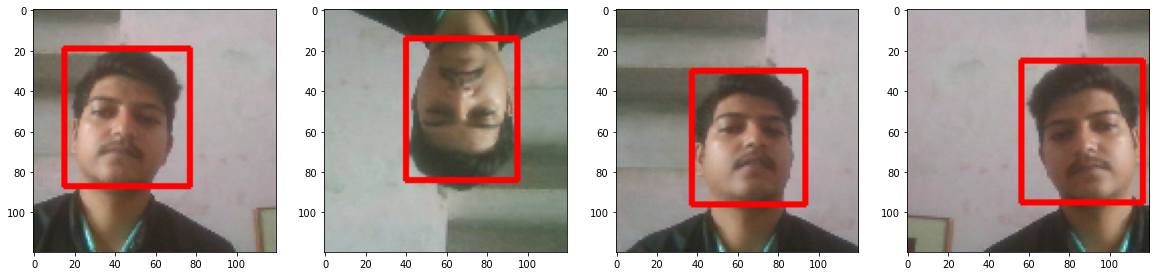

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image) # we get images augmented and annotated

## Build Deep Learning using the Functional API

In [71]:
# import layers and base network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [72]:
#Download VGG16
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 35s 1us/step


In [73]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [76]:
#Build instance of Network
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [75]:
#Test out Neural Network
facetracker = build_model()

In [77]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [78]:
X, y = train.as_numpy_iterator().next()

In [79]:
X.shape

(8, 120, 120, 3)

In [80]:
classes, coords = facetracker.predict(X)

In [81]:
classes, coords

(array([[0.4951786 ],
        [0.51196504],
        [0.50095034],
        [0.4983004 ],
        [0.55245006],
        [0.51276743],
        [0.5296249 ],
        [0.46272406]], dtype=float32),
 array([[0.27626097, 0.587707  , 0.3082671 , 0.5343649 ],
        [0.3508867 , 0.52364963, 0.43663546, 0.499111  ],
        [0.3311084 , 0.5540707 , 0.39371586, 0.5490389 ],
        [0.32671845, 0.49939814, 0.37144536, 0.4855414 ],
        [0.28953713, 0.55046135, 0.3512491 , 0.5246266 ],
        [0.2690489 , 0.6962596 , 0.27550745, 0.57639605],
        [0.27360708, 0.6043057 , 0.35707772, 0.49713644],
        [0.27718127, 0.6078537 , 0.33674803, 0.54054743]], dtype=float32))

## Define Losses and Optimizers

In [82]:
#Define Optimizer and LR
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [83]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [84]:
#Create Localization Loss and Classification Loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [85]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test out Loss Metrics

In [86]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.951415>

In [87]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6784588>

In [88]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.951415>

## Train Neural Network

In [90]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [91]:
model = FaceTracker(facetracker)

In [92]:
model.compile(opt, classloss, regressloss)

## Train

In [93]:
logdir='logs'

In [94]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [95]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
158/158 [==============================] - 806s 5s/step - total_loss: 0.1484 - class_loss: 0.0126 - regress_loss: 0.1421 - val_total_loss: 0.0609 - val_class_loss: 4.7387e-05 - val_regress_loss: 0.0608
Epoch 2/10
158/158 [==============================] - 740s 5s/step - total_loss: 0.0231 - class_loss: 3.1723e-05 - regress_loss: 0.0231 - val_total_loss: 0.0258 - val_class_loss: 1.7047e-05 - val_regress_loss: 0.0258
Epoch 3/10
158/158 [==============================] - 703s 4s/step - total_loss: 0.0150 - class_loss: 1.2427e-05 - regress_loss: 0.0150 - val_total_loss: 0.0374 - val_class_loss: 5.6476e-06 - val_regress_loss: 0.0374
Epoch 4/10
158/158 [==============================] - 682s 4s/step - total_loss: 0.0108 - class_loss: 7.5887e-06 - regress_loss: 0.0108 - val_total_loss: 0.0119 - val_class_loss: 1.0192e-05 - val_regress_loss: 0.0119
Epoch 5/10
158/158 [==============================] - 677s 4s/step - total_loss: 0.0082 - class_loss: 5.0302e-06 - regress_loss: 0.0082 

## Plot Performance

In [96]:
hist.history

{'total_loss': [0.007907696068286896,
  0.013670679181814194,
  0.004223959520459175,
  0.006120289675891399,
  0.0012019546702504158,
  0.003553902730345726,
  0.003246142528951168,
  0.002619683975353837,
  0.0012764112325385213,
  0.0017078754026442766],
 'class_loss': [7.48963575460948e-05,
  1.4662890862382483e-05,
  8.404294931096956e-06,
  7.5847492553293705e-06,
  2.9355364858929534e-06,
  2.384186643666908e-07,
  3.874303047268768e-07,
  2.980232594040899e-08,
  6.5565143358981e-07,
  7.301574669327238e-07],
 'regress_loss': [0.007870247587561607,
  0.01366334781050682,
  0.00421975739300251,
  0.006116497330367565,
  0.0012004869058728218,
  0.0035537835210561752,
  0.003245948813855648,
  0.002619669074192643,
  0.0012760834069922566,
  0.0017075103241950274],
 'val_total_loss': [0.06087353825569153,
  0.0258411206305027,
  0.0373709462583065,
  0.01193193718791008,
  0.03503512591123581,
  0.023570097982883453,
  0.06802548468112946,
  0.04353576898574829,
  0.0309871640056

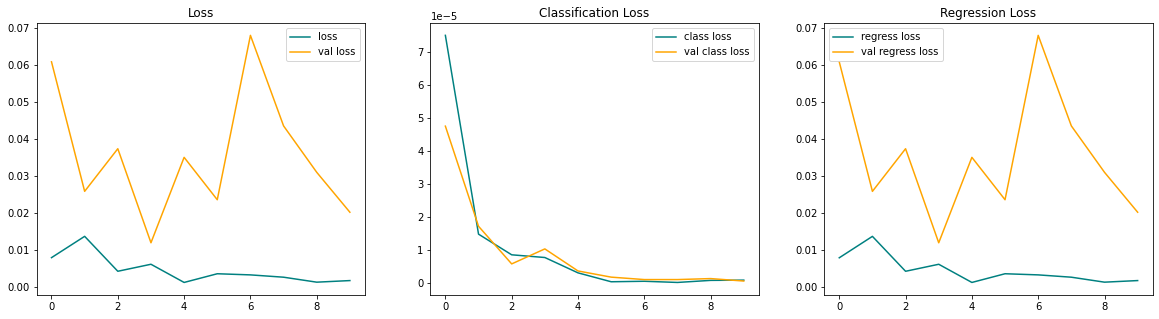

In [97]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

In [98]:
test_data = test.as_numpy_iterator()

In [99]:
test_sample = test_data.next()

In [100]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


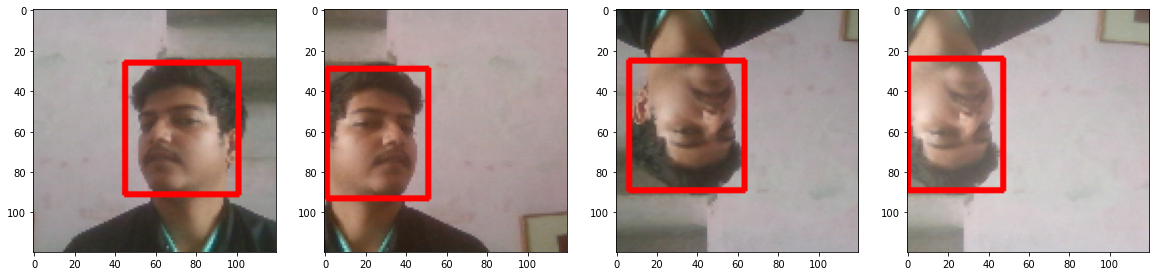

In [101]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save the Model

In [102]:
from tensorflow.keras.models import load_model

In [103]:
facetracker.save('facetracker.h5')

In [104]:
facetracker = load_model('facetracker.h5')

## Real Time Detection

In [106]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()